In [39]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [40]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [41]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [42]:
df.sort_values('Date',inplace=True)

In [43]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [44]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [45]:
JarirـMarketing = df[df['Company Name']== 'Jarir Marketing Co.']

In [46]:
JarirـMarketing_for_model = JarirـMarketing[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [47]:
JarirـMarketing_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
272383,2009-01-03,171.75,174.00,170.50,171.50,-0.50,-0.29
272381,2009-01-04,172.50,172.50,170.00,170.50,-1.00,-0.58
272403,2009-01-05,170.00,171.25,169.00,169.75,-0.75,-0.43
272404,2009-01-06,173.50,179.75,172.25,174.00,4.25,2.50


In [48]:
JarirـMarketing_for_model.reset_index(inplace=True)

In [49]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(JarirـMarketing_for_model["Date"][-(227):])[0]

In [50]:
split_date

Timestamp('2019-01-01 00:00:00')

In [51]:
JarirـMarketing_for_arima = JarirـMarketing_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [52]:
JarirـMarketing_for_arima.set_index('Date',inplace=True)

In [53]:
training_set, test_set = JarirـMarketing_for_model[JarirـMarketing_for_model['Date'] < split_date], JarirـMarketing_for_model[JarirـMarketing_for_model['Date'] >= split_date]


In [54]:
training_set.shape

(2495, 8)

In [55]:
test_set.shape

(227, 8)

In [56]:
test_set.set_index('Date',inplace=True)

In [57]:
training_set.set_index('Date',inplace=True)

In [58]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [59]:
training = training_set.values

In [60]:
testing = test_set.values

## LSTM

## Window length

In [61]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [62]:
LSTM_test_inputs.shape

(222, 5, 6)

In [63]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [64]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [65]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [66]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 456us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 2/120
1992/1992 [==============================] - 0s 248us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 3/120
1992/1992 [==============================] - 1s 252us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 4/120
1992/1992 [==============================] - 0s 248us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 5/120
1992/1992 [==============================] - 0s 243us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 6/120
1992/1992 [==============================] - 0s 245us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 7/120
1992/1992 [==============================] - 0s 242us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 8/120
1992/1992 [==============================] - 0s 243us/step - loss: 163.7828 - val_loss: 155.0117
Epoch 9/120
1992/1992 [==============================] - 0s 241us/step - loss: 16

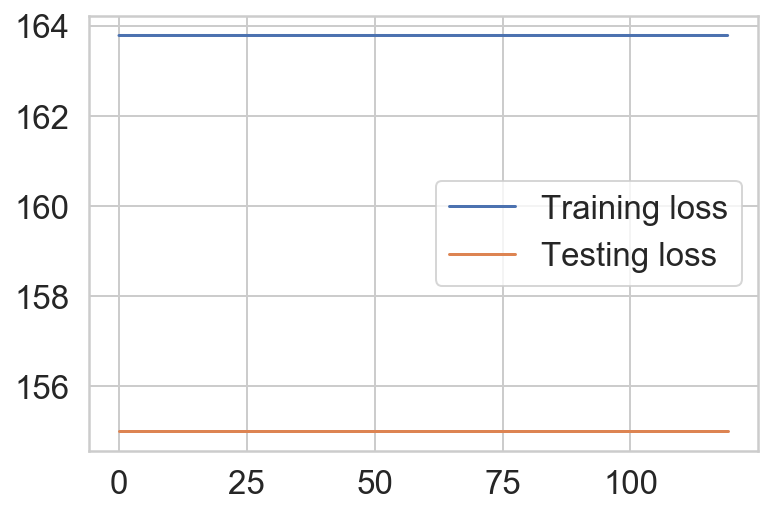

In [94]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [95]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [96]:
y = JarirـMarketing_for_arima['Close'].resample('MS').mean()

In [97]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [98]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1698.3602029420058
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1440.6230493355529
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1229.0764150381387
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1205.2307995949468
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1056.6114392120123
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:940.5269773991932
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1191.5822608626136
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1000.9366628015116
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:878.1913912052742
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1216.0069549364807
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1174.1113008668872
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1056.1283693973833
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1093.676020723009
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1056.8375813344007
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:941.419391693122
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1046.608057162047
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:998.5786611811496
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:868.9356730809353


ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:741.1433280347158
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:876.2916951437555
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:815.1433682344658
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:686.8532726756398
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:858.7709254075224
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:858.1590131621732
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:833.2935868002471
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:785.0155645612574
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:768.0805917538707
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:742.8530924684216
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:746.8429510668777
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:718.7415850011607
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:696.6508698357283
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:1092.8395019035167
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:991.7204201671367
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:897.2117424973848
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:1081.2495117556975
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:923.544207109133
ARIMA(0, 

ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:930.0634704078342
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:846.1208694875731
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1005.6705682291662
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:855.4715877932754
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:753.9228009634079
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:1018.8487846598946
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:832.0462088558309
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:719.560218899622
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:944.3899205093974
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:932.0356004956456
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:841.9767593042836
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:901.0193625246582
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:856.5658933448715
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:746.6821585535988
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:873.587150624446
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:821.3621158783577
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:694.6104971402888
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:860.6420561312098
ARIMA(1, 0

ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:864.3877231692775
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:821.3667960515131
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:692.3383965345021
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:848.8737785886001
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:843.6876966643301
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:835.0202432816164
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:774.0569461643105
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:757.9791780372939
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:745.4848672347237
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:734.9914985918729
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:710.2739212931576
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:699.791033893368
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:1010.6494204074628
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:920.2901934972394
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:834.0842160820181
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:1000.7908953252524
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:849.0042822592469
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:746.5179330885409
ARIMA(1, 

ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:859.4158482492337
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:757.4125569025954
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:1024.9858062711137
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:837.2447760052706
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:696.2368848424568
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:927.2795820213837
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:929.2402543854578
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:843.8297221498285
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:889.934934588221
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:860.5707127054699
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:749.1654210848532
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:861.044373319918
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:825.6645121033446
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:696.5417077990965
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:844.2058942072232
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:846.3406848680008
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:845.8289557628542
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:771.7947515421145
ARIMA(2, 1,

In [72]:
#ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:390.88788508639425

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0049      0.100     -0.049      0.961      -0.201       0.191
ma.L2          0.0190      0.135      0.140      0.888      -0.246       0.283
ma.S.L12      -1.9735   1288.548     -0.002      0.999   -2527.481    2523.534
ma.S.L24       1.0005   1306.851      0.001      0.999   -2560.380    2562.381
sigma2       178.8276   2.34e+05      0.001      0.999   -4.58e+05    4.58e+05


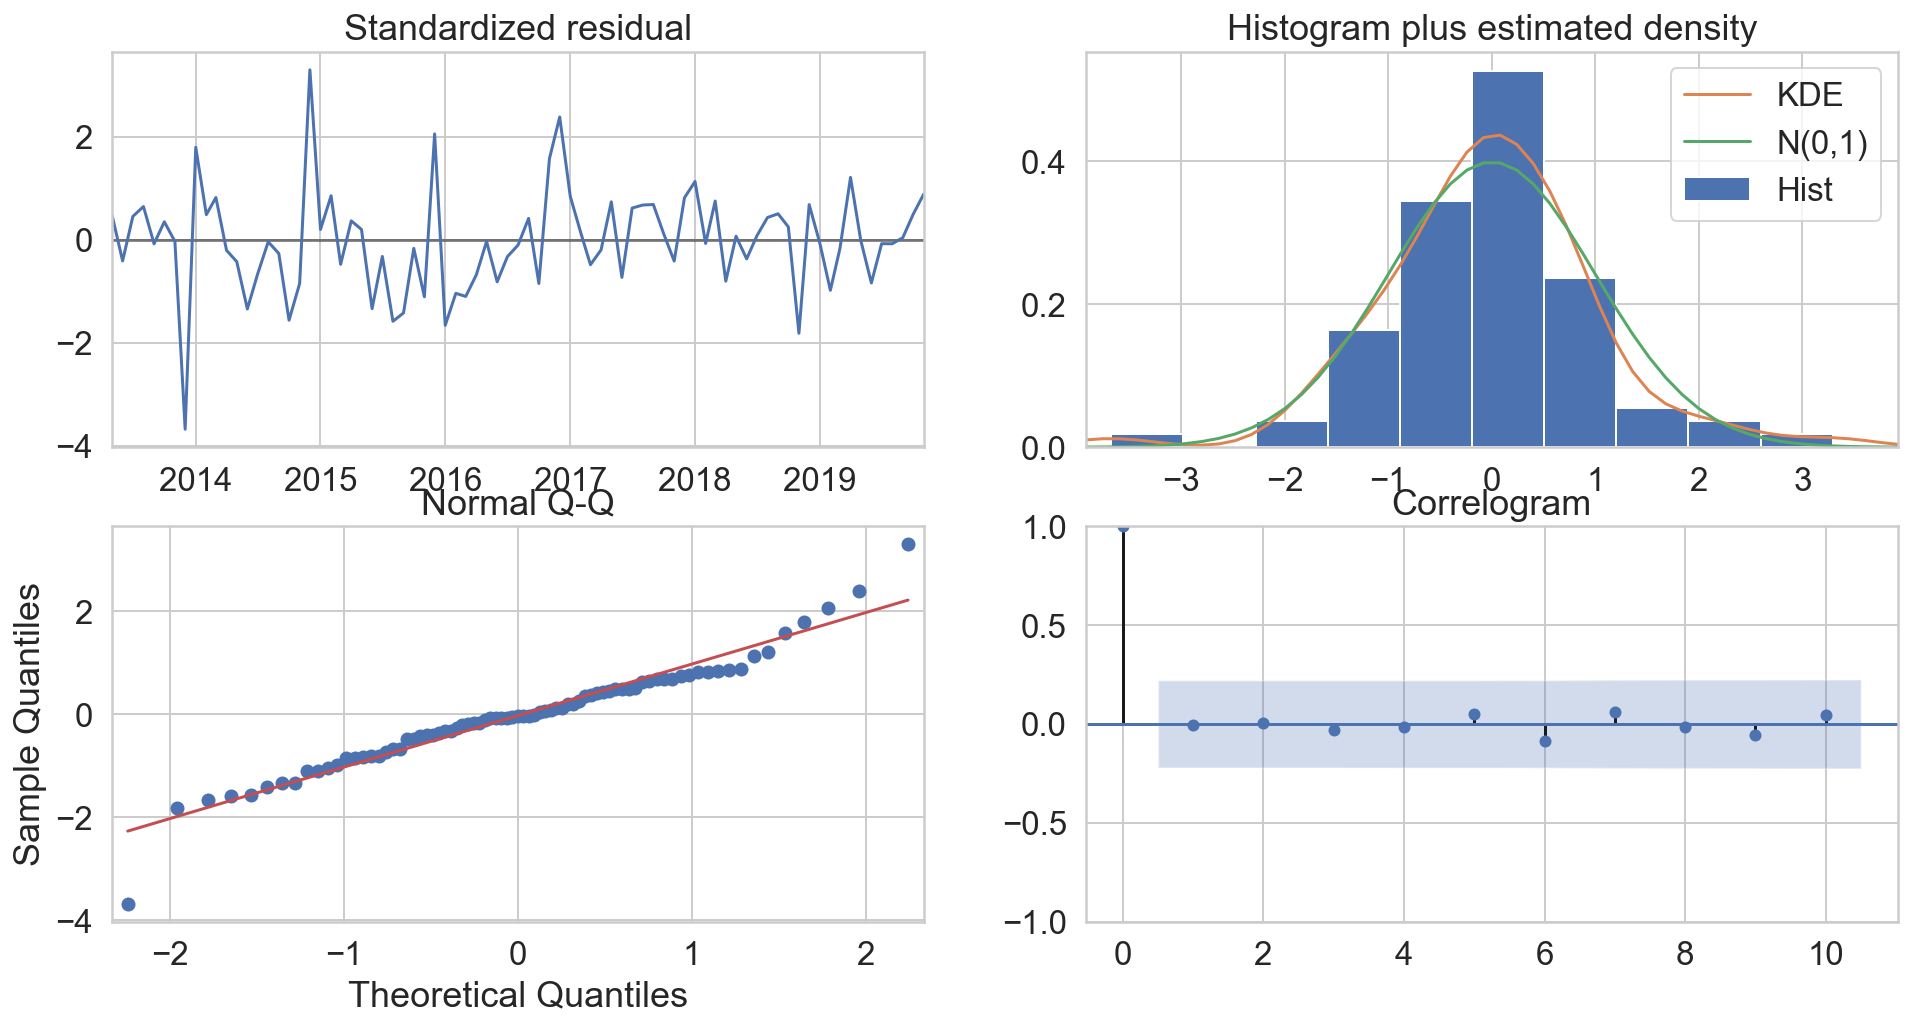

In [73]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

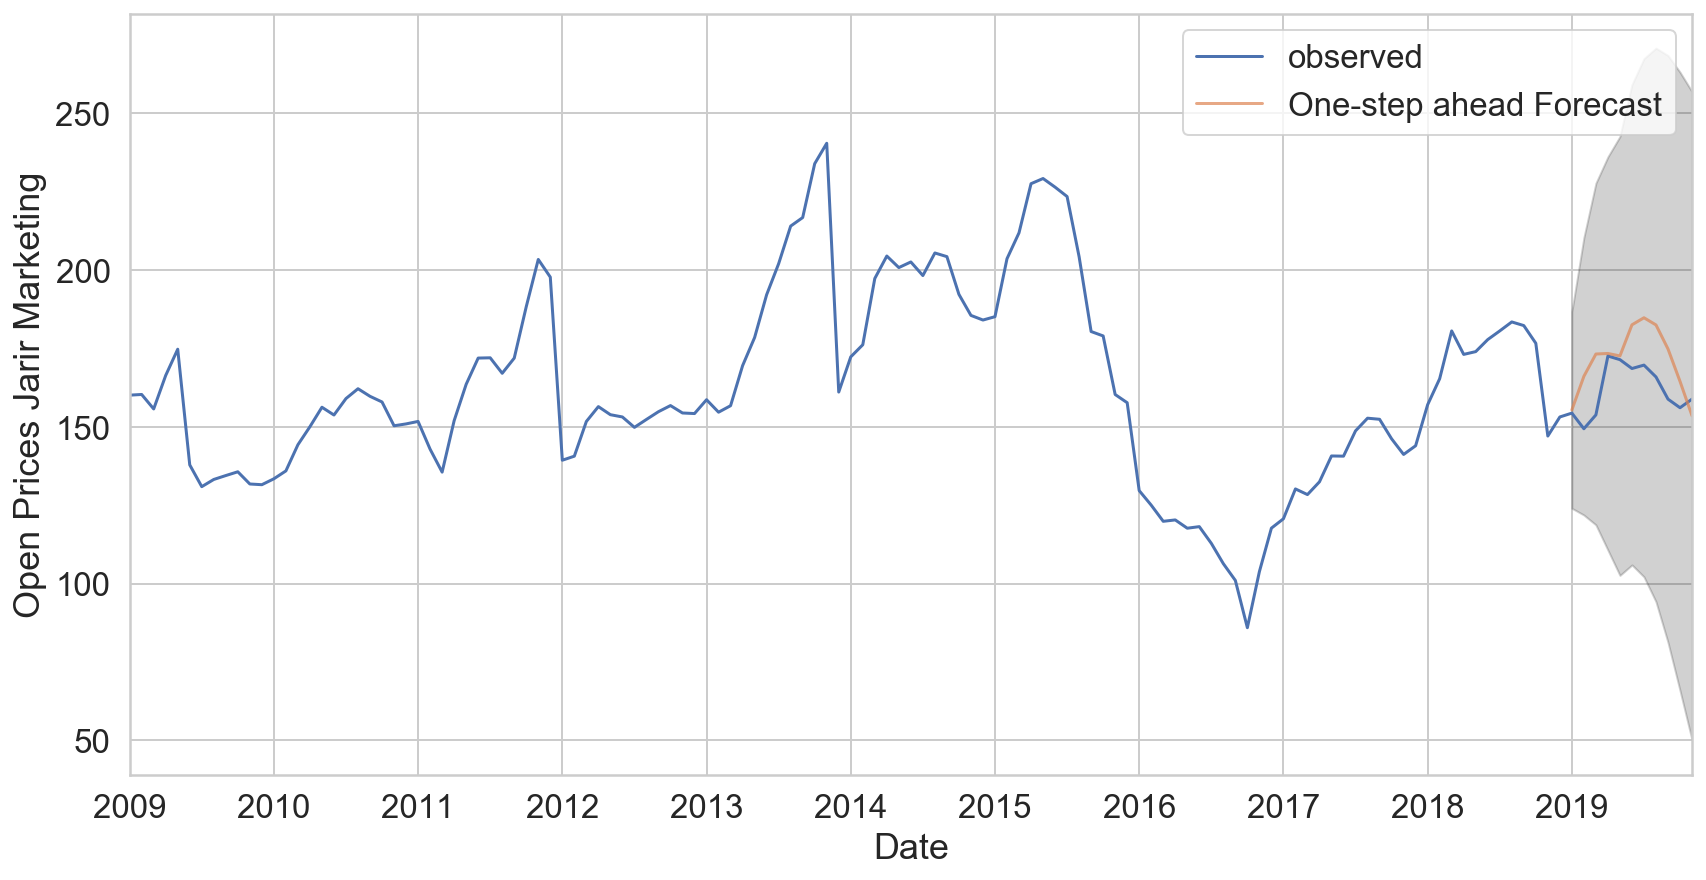

In [74]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices Jarir Marketing')
plt.legend()
plt.show()

In [75]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 155.5


In [76]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 12.47


## Producing and visualizing forecasts

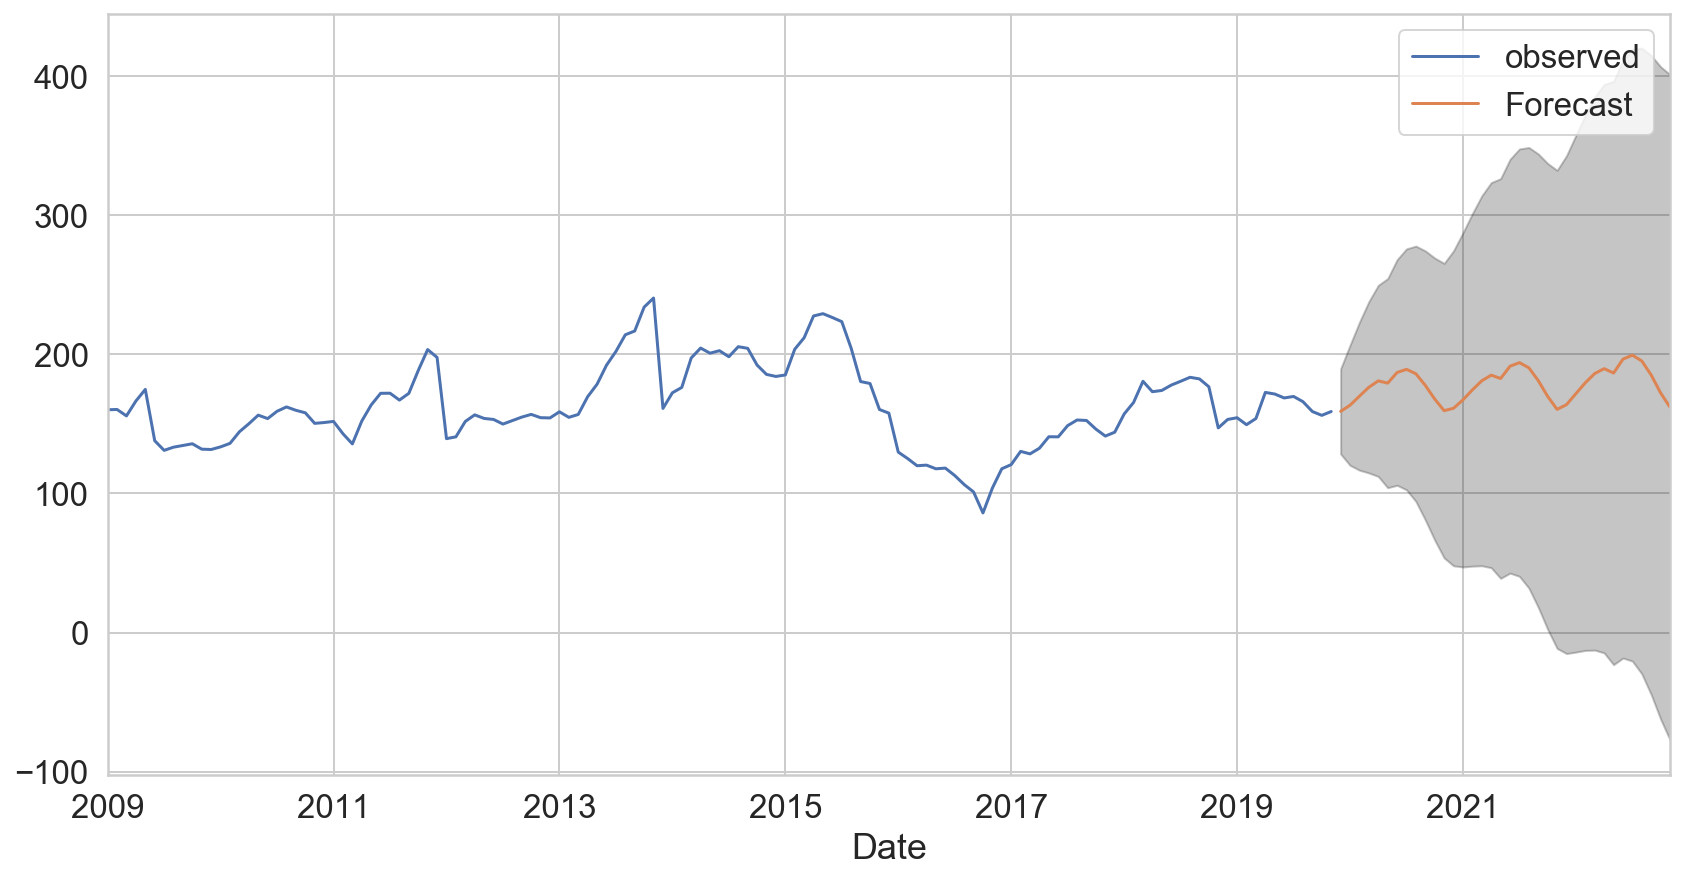

In [77]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [115]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [116]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [117]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [118]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [119]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

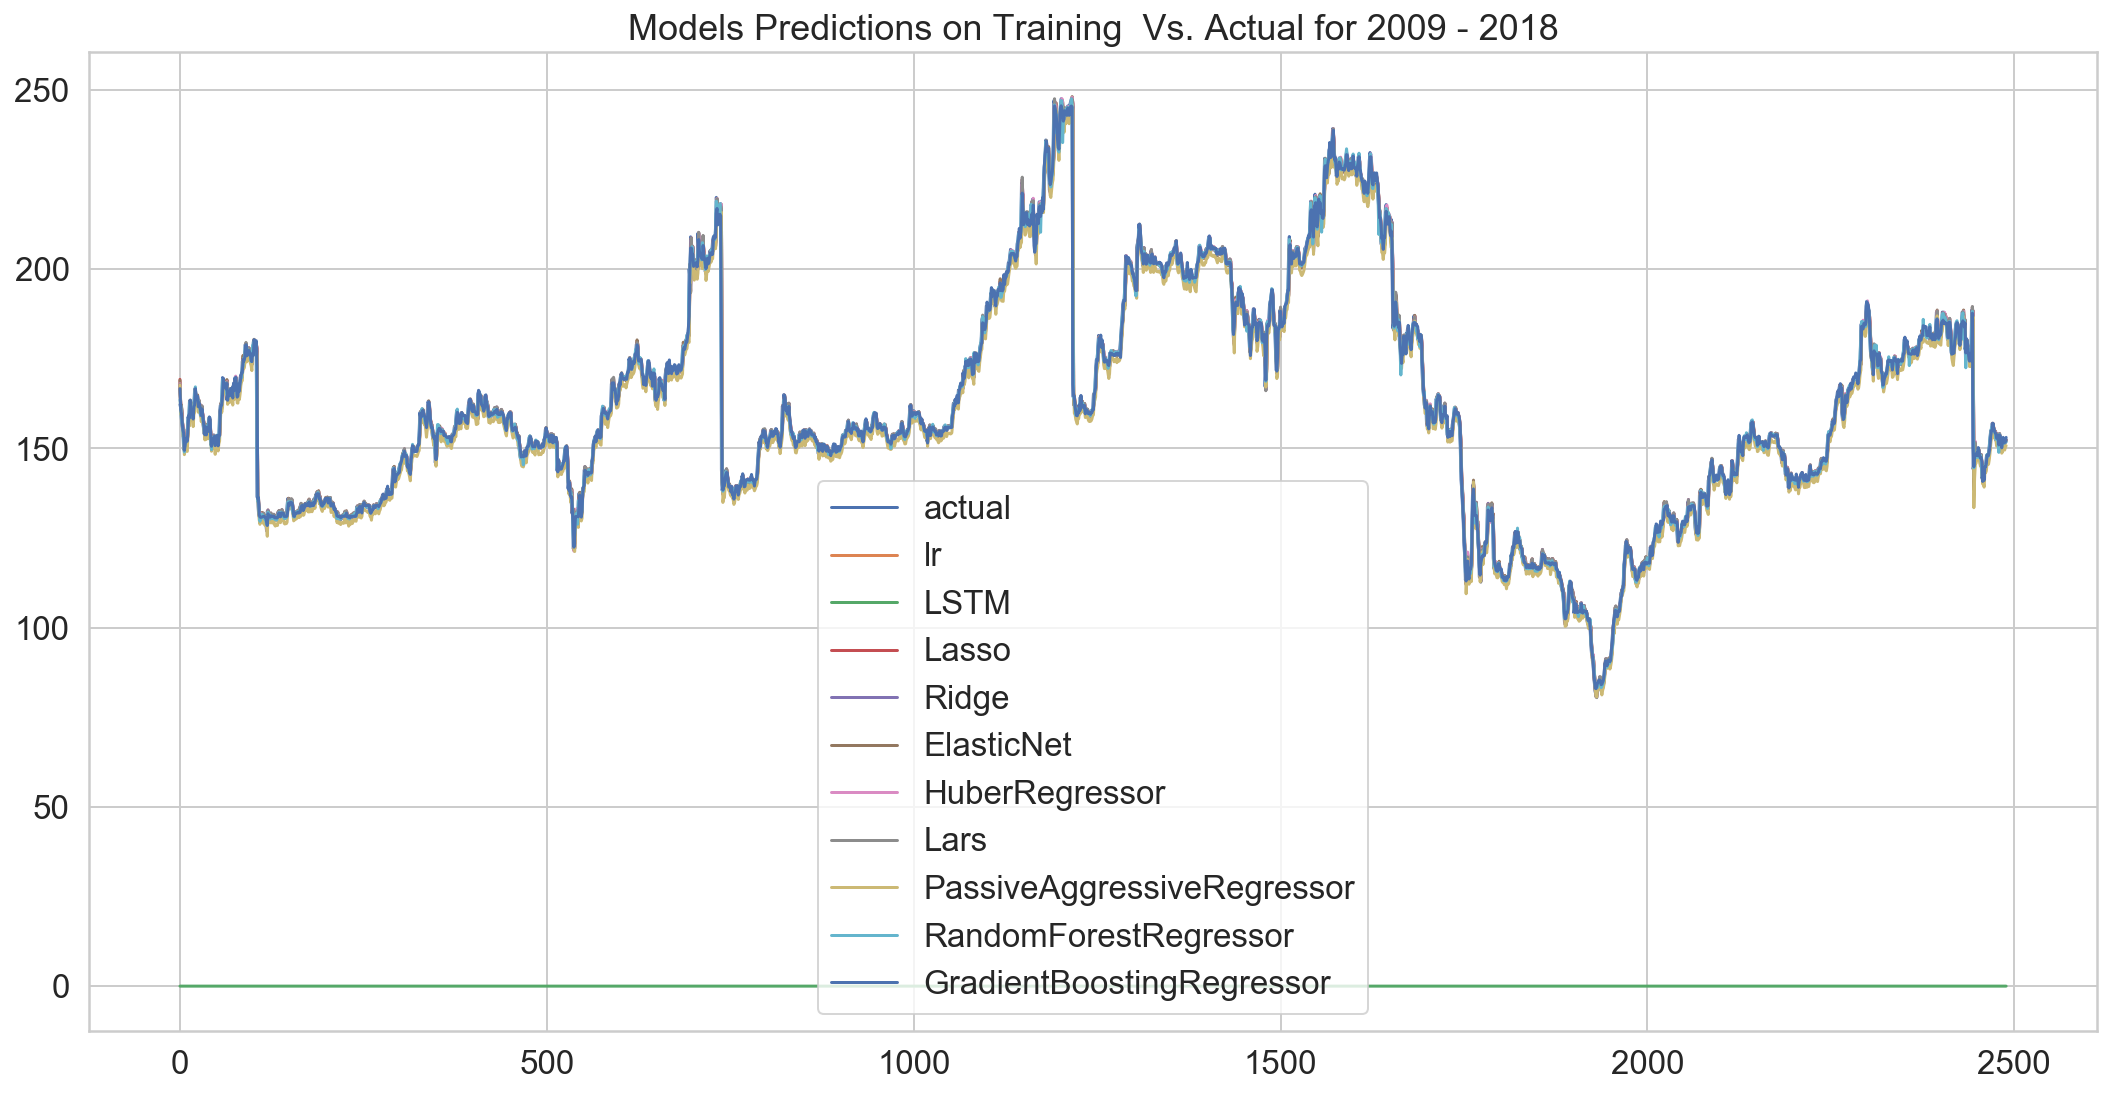

In [120]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

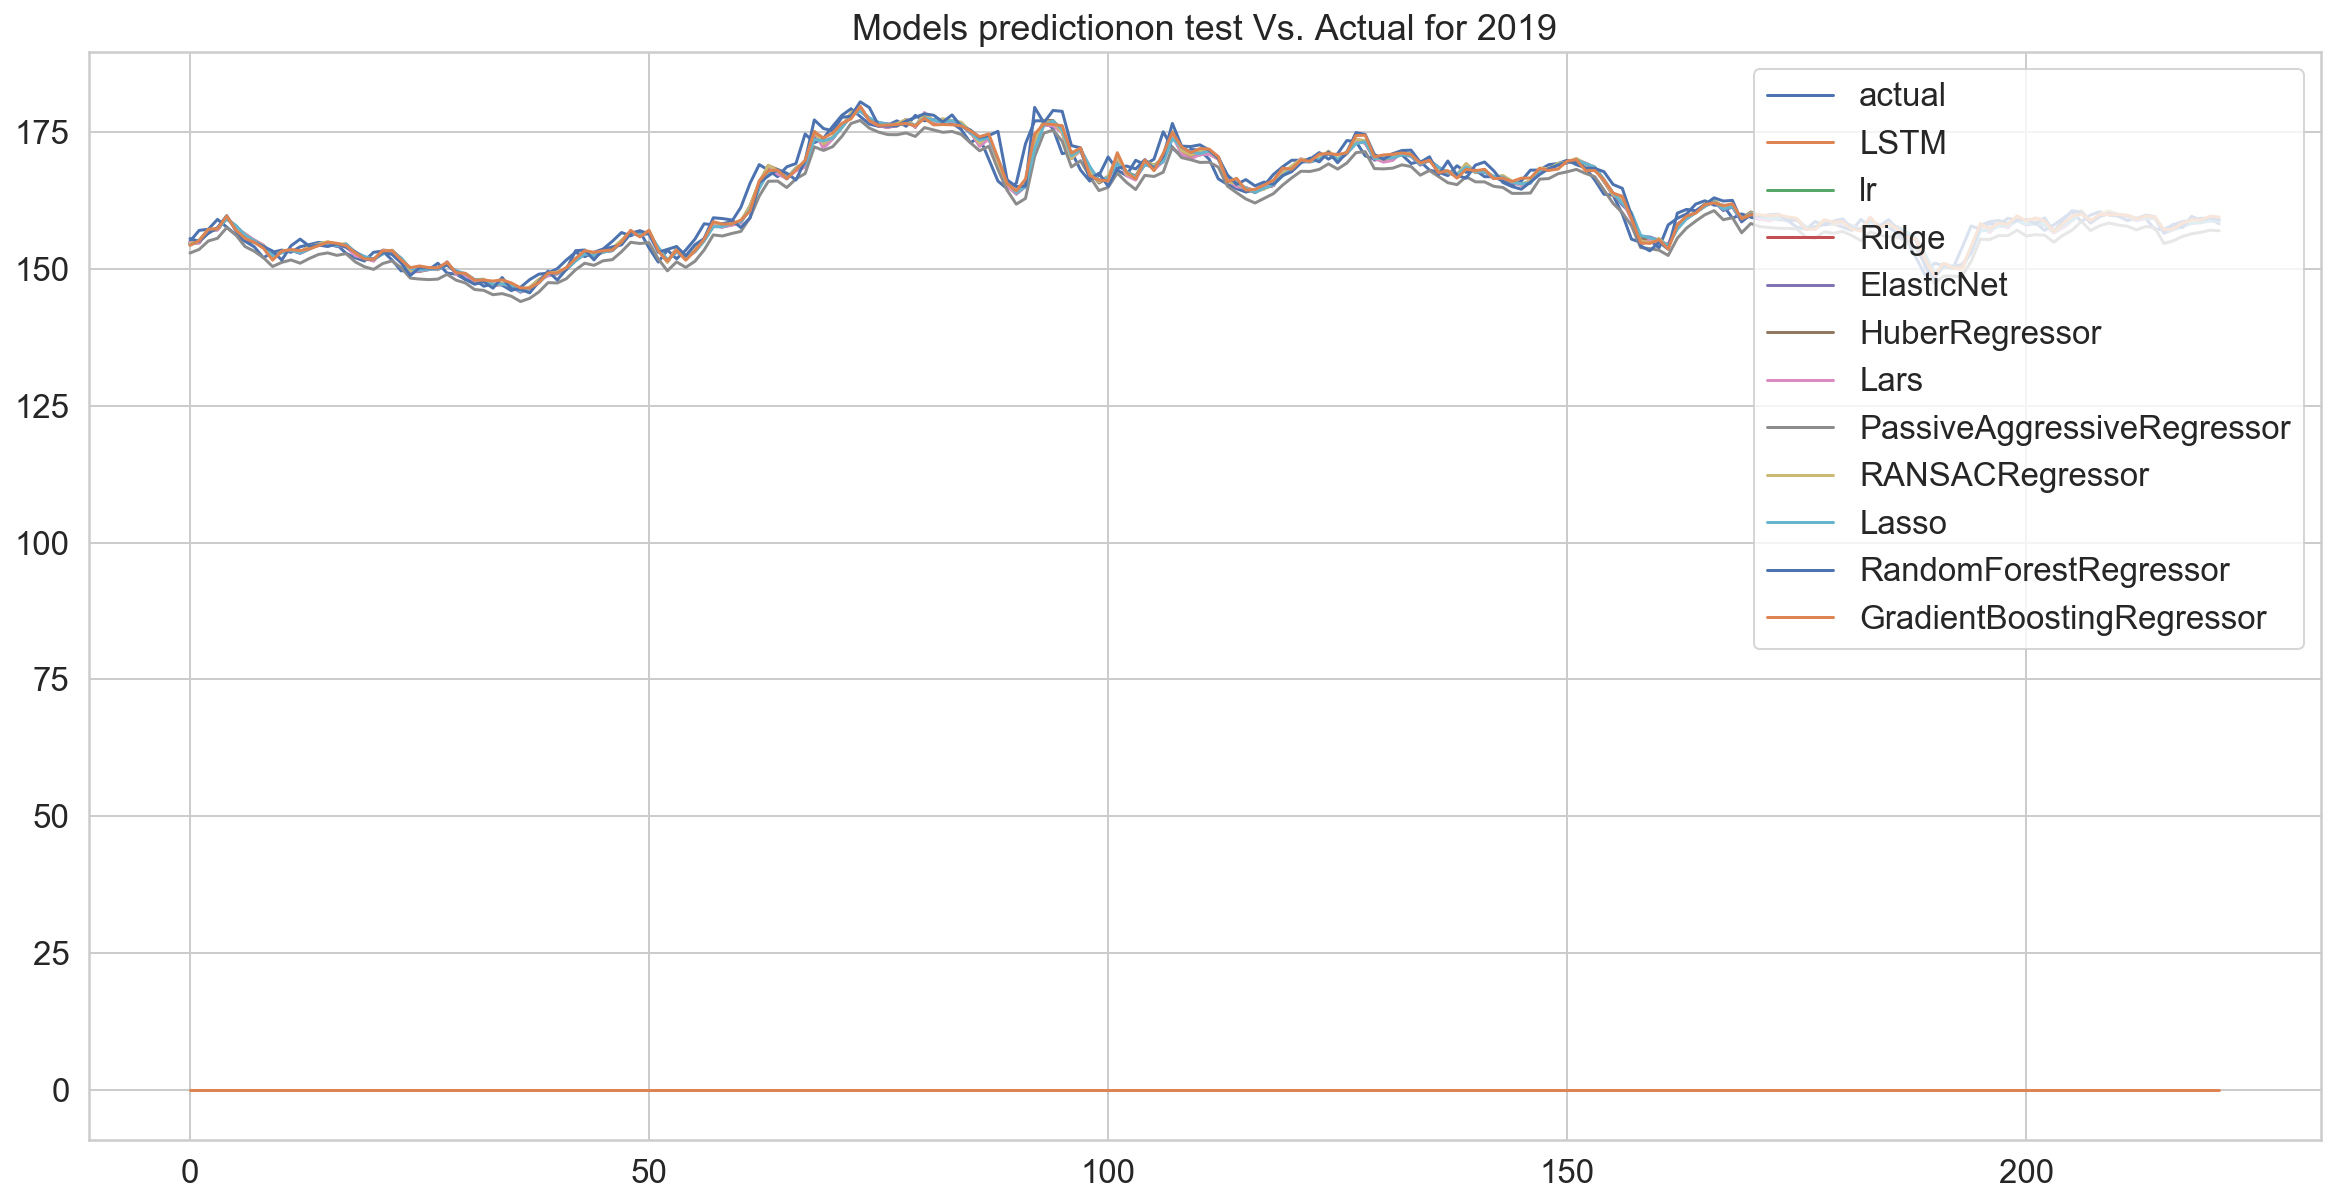

In [121]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [122]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [123]:
predictions_test.head()

,Actual,Lr,Lasso,Ridge,ElasticNet,PassiveAggressiveRegressor,HuberRegressor,Lars,RANSACRegressor,LSTM,RandomForestRegressor,GradientBoostingRegressor
0,155.0,154.724436,154.311738,154.724161,154.414686,152.859167,154.485332,154.761317,154.561118,0.0,155.500,154.270631
1,157.0,154.744448,155.017532,154.744400,155.057522,153.520801,154.855011,154.666777,155.253450,0.0,154.975,155.097625
2,157.2,157.123840,156.681455,157.123616,156.771766,155.057099,156.909286,157.093974,157.164139,0.0,156.453,157.175868
3,159.0,157.119988,157.308445,157.119829,157.323399,155.551092,157.148110,157.063296,157.333876,0.0,157.493,157.295798
4,157.6,159.371033,159.017682,159.371305,159.169625,157.496490,159.322269,159.428166,159.306065,0.0,159.679,159.597616


## Validating our model

In [124]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [125]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [126]:
df_new.sort_values('Date',inplace=True)

In [127]:
df_new.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
2121,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-03,17.06,17.06,16.78,16.90,-0.26,-1.52,147529,2494172.96,325
2123,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-04,17.38,17.38,17.18,17.18,-0.20,-1.15,142735,2465908.84,205
2133,Insurance,8290,Solidarity Saudi Takaful Co.,2009-01-05,10.32,10.36,10.30,10.34,-0.02,-0.19,47405,489919.30,106
2118,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-06,17.42,17.54,17.40,17.50,0.00,0.00,117410,2049337.42,222


In [128]:
JarirـMarketing_2_weeks = df_new[df_new['Company Name']== 'Jarir Marketing Co.']

In [129]:
JarirـMarketing_2_weeks

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
1253,Retailing,4190,Jarir Marketing Co.,2014-08-17,156.2,160.2,156.2,159.0,-0.2,-0.13,133047,21194969.8,375
1254,Retailing,4190,Jarir Marketing Co.,2014-08-18,158.0,158.4,157.0,158.4,0.6,0.38,136084,21491385.6,413
1250,Retailing,4190,Jarir Marketing Co.,2014-08-19,160.0,160.8,159.2,160.0,0.2,0.13,73250,11715967.8,349
1251,Retailing,4190,Jarir Marketing Co.,2014-08-20,158.6,159.2,157.2,159.2,1.0,0.63,73873,11716732.4,410
1252,Retailing,4190,Jarir Marketing Co.,2014-08-21,159.2,159.2,157.2,158.2,-1.0,-0.63,79280,12506928.8,477
1256,Retailing,4190,Jarir Marketing Co.,2014-09-03,158.2,159.4,157.8,159.2,0.8,0.51,133477,21201890.8,1464
1255,Retailing,4190,Jarir Marketing Co.,2014-09-10,160.0,162.0,160.0,161.0,1.0,0.63,94430,15187706.0,601
1249,Retailing,4190,Jarir Marketing Co.,2015-02-24,158.2,158.2,157.0,157.8,-0.4,-0.25,75304,11882543.2,215
1247,Retailing,4190,Jarir Marketing Co.,2015-03-01,160.0,161.8,159.8,159.8,0.8,0.50,403067,62646407.2,733
1248,Retailing,4190,Jarir Marketing Co.,2015-03-02,161.8,161.8,160.0,160.2,0.2,0.13,67638,10848445.8,196


In [131]:
JarirـMarketing2w_for_model = JarirـMarketing_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [132]:
JarirـMarketing2w_for_model

,Date,Open,High,Low,Close,Change,% Change
1253,2014-08-17,156.2,160.2,156.2,159.0,-0.2,-0.13
1254,2014-08-18,158.0,158.4,157.0,158.4,0.6,0.38
1250,2014-08-19,160.0,160.8,159.2,160.0,0.2,0.13
1251,2014-08-20,158.6,159.2,157.2,159.2,1.0,0.63
1252,2014-08-21,159.2,159.2,157.2,158.2,-1.0,-0.63
1256,2014-09-03,158.2,159.4,157.8,159.2,0.8,0.51
1255,2014-09-10,160.0,162.0,160.0,161.0,1.0,0.63
1249,2015-02-24,158.2,158.2,157.0,157.8,-0.4,-0.25
1247,2015-03-01,160.0,161.8,159.8,159.8,0.8,0.50
1248,2015-03-02,161.8,161.8,160.0,160.2,0.2,0.13


In [133]:
JarirـMarketing2w_for_model.reset_index(inplace=True)

In [134]:
asm = JarirـMarketing_for_model[-6:]

In [135]:
asm

,index,Date,Open,High,Low,Close,Change,% Change
2716,270290,2019-11-21,157.0,158.0,156.2,158.0,0.8,0.51
2717,270271,2019-11-24,157.0,158.6,157.0,158.6,0.6,0.38
2718,270270,2019-11-25,158.0,159.0,157.0,158.8,0.2,0.13
2719,270269,2019-11-26,158.8,159.2,157.2,159.2,0.4,0.25
2720,270268,2019-11-27,158.8,159.2,157.2,159.2,0.0,0.00
2721,270267,2019-11-28,158.2,158.8,157.2,158.2,-1.0,-0.63


In [136]:
JarirـMarketing2w_for_model

,index,Date,Open,High,Low,Close,Change,% Change
0,1253,2014-08-17,156.2,160.2,156.2,159.0,-0.2,-0.13
1,1254,2014-08-18,158.0,158.4,157.0,158.4,0.6,0.38
2,1250,2014-08-19,160.0,160.8,159.2,160.0,0.2,0.13
3,1251,2014-08-20,158.6,159.2,157.2,159.2,1.0,0.63
4,1252,2014-08-21,159.2,159.2,157.2,158.2,-1.0,-0.63
5,1256,2014-09-03,158.2,159.4,157.8,159.2,0.8,0.51
6,1255,2014-09-10,160.0,162.0,160.0,161.0,1.0,0.63
7,1249,2015-02-24,158.2,158.2,157.0,157.8,-0.4,-0.25
8,1247,2015-03-01,160.0,161.8,159.8,159.8,0.8,0.50
9,1248,2015-03-02,161.8,161.8,160.0,160.2,0.2,0.13


In [137]:
abr = asm.merge(JarirـMarketing2w_for_model, how='outer')

In [138]:
abr.set_index('Date',inplace=True)

In [139]:
abr.pop('index')

Date
2019-11-21    270290
2019-11-24    270271
2019-11-25    270270
2019-11-26    270269
2019-11-27    270268
2019-11-28    270267
2014-08-17      1253
2014-08-18      1254
2014-08-19      1250
2014-08-20      1251
2014-08-21      1252
2014-09-03      1256
2014-09-10      1255
2015-02-24      1249
2015-03-01      1247
2015-03-02      1248
2015-03-05      1246
Name: index, dtype: int64

In [140]:
abr

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-11-21,157.0,158.0,156.2,158.0,0.8,0.51
2019-11-24,157.0,158.6,157.0,158.6,0.6,0.38
2019-11-25,158.0,159.0,157.0,158.8,0.2,0.13
2019-11-26,158.8,159.2,157.2,159.2,0.4,0.25
2019-11-27,158.8,159.2,157.2,159.2,0.0,0.00
2019-11-28,158.2,158.8,157.2,158.2,-1.0,-0.63
2014-08-17,156.2,160.2,156.2,159.0,-0.2,-0.13
2014-08-18,158.0,158.4,157.0,158.4,0.6,0.38
2014-08-19,160.0,160.8,159.2,160.0,0.2,0.13


In [141]:
abr2=abr[1:].values

In [142]:
abr2

array([[ 1.570e+02,  1.586e+02,  1.570e+02,  1.586e+02,  6.000e-01,
         3.800e-01],
       [ 1.580e+02,  1.590e+02,  1.570e+02,  1.588e+02,  2.000e-01,
         1.300e-01],
       [ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  4.000e-01,
         2.500e-01],
       [ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  0.000e+00,
         0.000e+00],
       [ 1.582e+02,  1.588e+02,  1.572e+02,  1.582e+02, -1.000e+00,
        -6.300e-01],
       [ 1.562e+02,  1.602e+02,  1.562e+02,  1.590e+02, -2.000e-01,
        -1.300e-01],
       [ 1.580e+02,  1.584e+02,  1.570e+02,  1.584e+02,  6.000e-01,
         3.800e-01],
       [ 1.600e+02,  1.608e+02,  1.592e+02,  1.600e+02,  2.000e-01,
         1.300e-01],
       [ 1.586e+02,  1.592e+02,  1.572e+02,  1.592e+02,  1.000e+00,
         6.300e-01],
       [ 1.592e+02,  1.592e+02,  1.572e+02,  1.582e+02, -1.000e+00,
        -6.300e-01],
       [ 1.582e+02,  1.594e+02,  1.578e+02,  1.592e+02,  8.000e-01,
         5.100e-01],
       [ 1.600e+02,  

In [143]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [144]:
X_valid

array([[[ 1.570e+02,  1.586e+02,  1.570e+02,  1.586e+02,  6.000e-01,
          3.800e-01],
        [ 1.580e+02,  1.590e+02,  1.570e+02,  1.588e+02,  2.000e-01,
          1.300e-01],
        [ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  4.000e-01,
          2.500e-01],
        [ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  0.000e+00,
          0.000e+00],
        [ 1.582e+02,  1.588e+02,  1.572e+02,  1.582e+02, -1.000e+00,
         -6.300e-01]],

       [[ 1.580e+02,  1.590e+02,  1.570e+02,  1.588e+02,  2.000e-01,
          1.300e-01],
        [ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  4.000e-01,
          2.500e-01],
        [ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  0.000e+00,
          0.000e+00],
        [ 1.582e+02,  1.588e+02,  1.572e+02,  1.582e+02, -1.000e+00,
         -6.300e-01],
        [ 1.562e+02,  1.602e+02,  1.562e+02,  1.590e+02, -2.000e-01,
         -1.300e-01]],

       [[ 1.588e+02,  1.592e+02,  1.572e+02,  1.592e+02,  4.000e-01,
          2.500e-

In [145]:
X_valid_resaped = X_valid.reshape(11,30)

In [146]:
y_valid

array([158.2, 159. , 158.4, 160. , 159.2, 158.2, 159.2, 161. , 157.8,
       159.8, 160.2, 160. ])

In [147]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

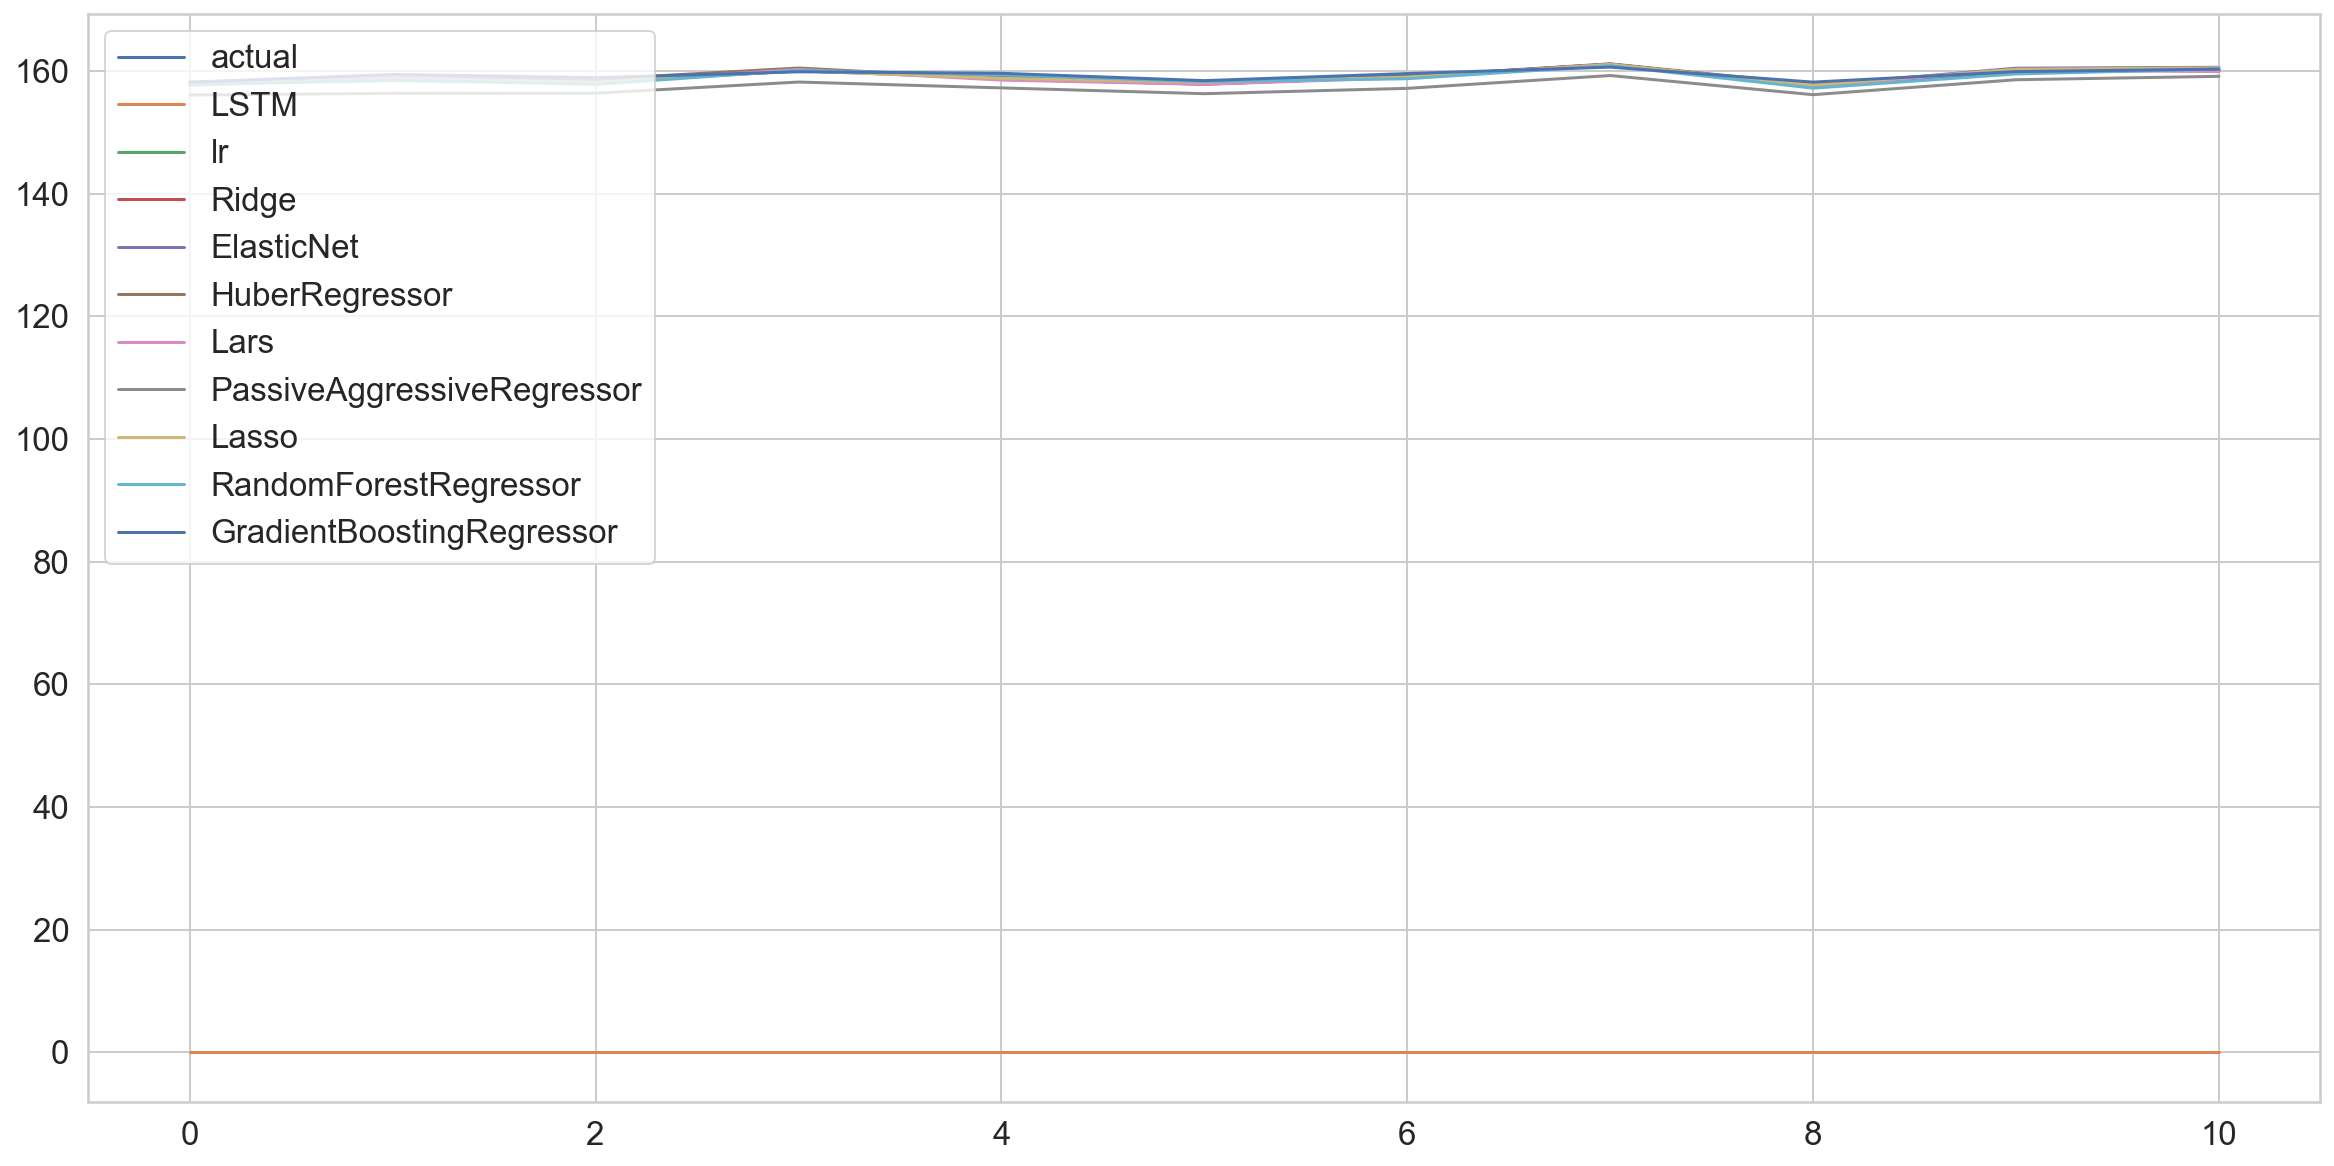

In [148]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [149]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [150]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [151]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [152]:
R2_score_test_LSTM

-371.67539350013436

In [153]:
R2_traininig_score_LSTM

-27.48849852696969

In [154]:
R2_score_valid_LSTM

-28221.658689248914

In [155]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [156]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [157]:
R2_scores

,models,Training_R2,Test_R2,valid_R2
0,LSTM,-27.488499,-371.675394,-28221.658689
1,LR,0.988311,0.958924,0.912792
2,lasso,0.987865,0.955951,0.917436
3,ridge,0.988311,0.958926,0.912749
4,en,0.987932,0.957272,0.868102
5,huber,0.988152,0.959616,0.924633
6,lars,0.988296,0.957913,0.861749
7,pa,0.984491,0.905485,-2.868107
8,gboost,0.995298,0.959468,0.876599
9,rt,0.998044,0.942578,0.854062


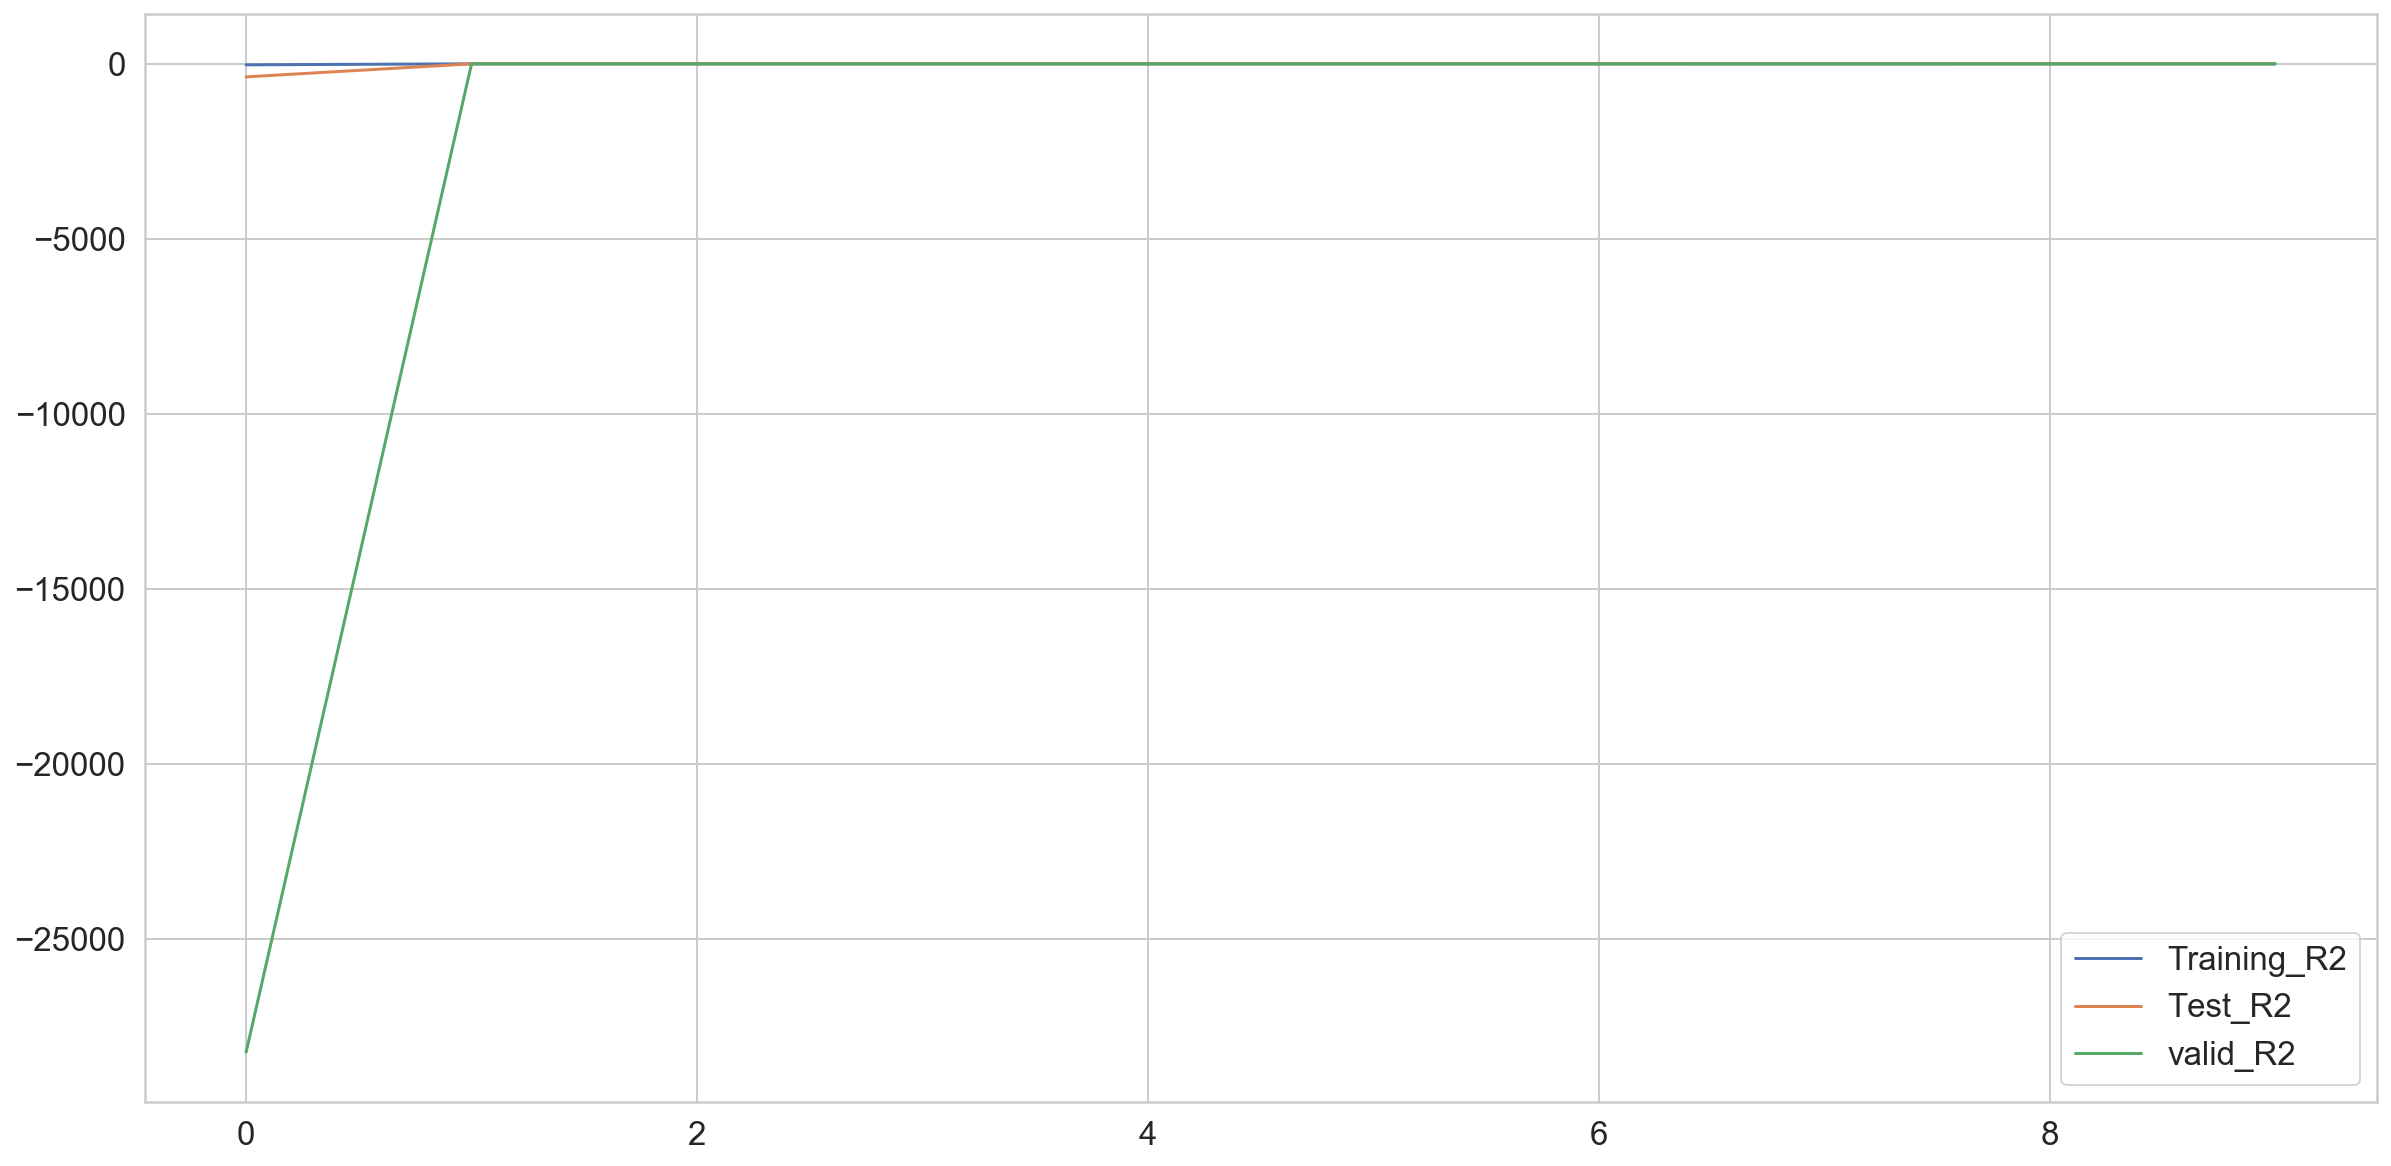

In [158]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()